# Multiday registration example notebook

This is a general purpose notebook that takes you step-by-step through the multiday registration process.


## Checking results.
After some steps a GUI is created which allows you to check the result of a certain process.
It is highly advised to always do this to make sure nothing unexpected is happening!

# Setup

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pickle
from multiday_suite2p import transform
from multiday_suite2p.io import registration_data_folder

# Load general settings file.
Select the general settings file that contains the processing parameters

In [2]:
from multiday_suite2p.settings import select_settings_file, parse_settings, parse_data_info
fc_settings = select_settings_file()

FileChooser(path='/local/workdir/yd478/registration/multiday-suite2p-public', filename='', title='', show_hidd…

In [6]:
settings = parse_settings(fc_settings.selected,request_pass=True)

# Load animal data info file.
Select settings file that contains the animal and data info.

In [7]:
fc_data = select_settings_file(fc_settings.selected_path)

FileChooser(path='/local/workdir/yd478/registration/multiday-suite2p-public/settings', filename='', title='', …

In [8]:
data_info = parse_data_info(fc_data.selected)

## Import Sessions

In [9]:
from multiday_suite2p.io import import_sessions
sessions, images, cells, im_size, label_im = import_sessions(data_info,settings, verbose=True)

2023_02_27/1 contained info for 3172 cells
2023_02_28/1 contained info for 2295 cells


### Save

In [10]:
with open(registration_data_folder(data_info)/'import.pkl', 'wb') as f:
    pickle.dump([sessions, images, cells, im_size, label_im], f)

### Load

In [11]:
with open(registration_data_folder(data_info)/'import.pkl','rb') as f:  
    sessions, images, cells, im_size, label_im = pickle.load(f)

# View imported data

Use Matplotlib build-in widgets to zoom in/out and pan.

Output()

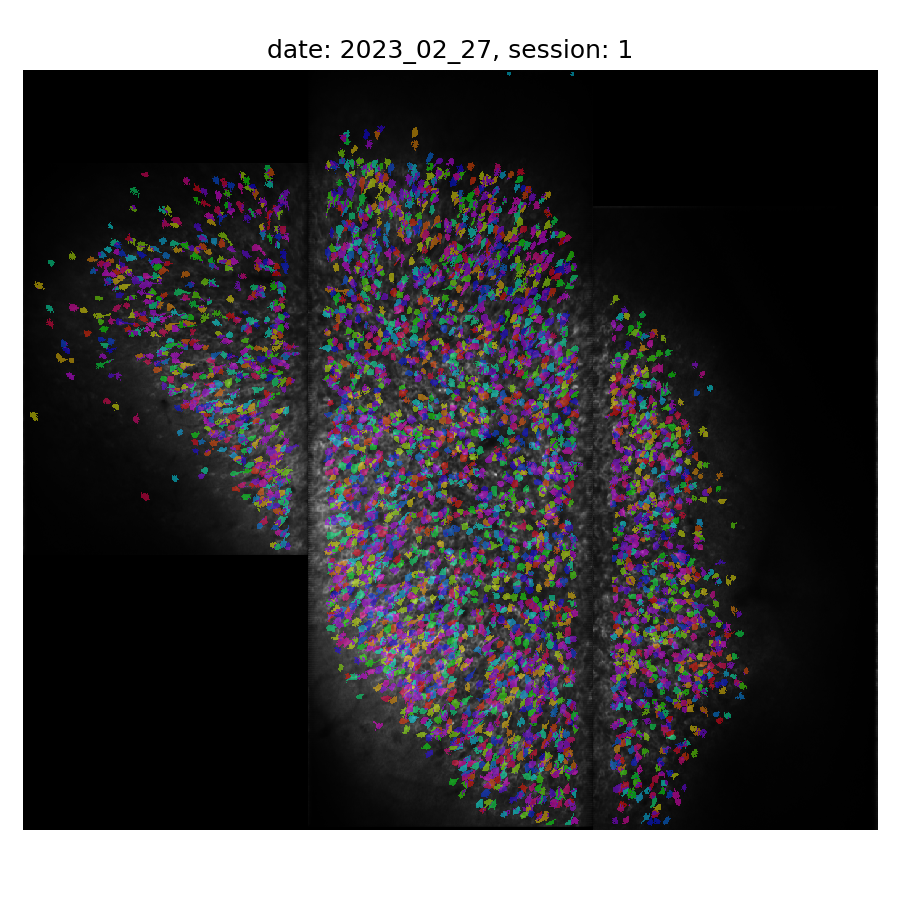

In [12]:
%matplotlib widget
from multiday_suite2p.gui import show_imgs_with_masks

show_imgs_with_masks(sessions,images,{'Single Session Masks':label_im})

# Register session

Groupwise difeomorphic demons registration of imaging planes across different sessions using diffeomorphic demons registration.

See [Pirt documentation](https://pirt.readthedocs.io/reg.html#pirt.DiffeomorphicDemonsRegistration) for more info


In [13]:
%%time
from multiday_suite2p.transform import register_sessions
# register.
deforms, trans_images = register_sessions(images, settings['registration'])

CPU times: user 10.2 s, sys: 6.58 s, total: 16.8 s
Wall time: 17 s


In [14]:
trans_masks, trans_label_im = transform.transform_cell_masks(deforms,cells)

100%|██████████| 2/2 [00:20<00:00, 10.37s/it]


### Save

In [15]:
with open(registration_data_folder(data_info)/'register.pkl', 'wb') as f:
    pickle.dump([deforms, trans_images,trans_masks, trans_label_im], f)

### Load

In [16]:
with open(registration_data_folder(data_info)/'register.pkl','rb') as f:  
    deforms, trans_images,trans_masks, trans_label_im = pickle.load(f)

# View Registration Results

Use Matplotlib build-in widgets to zoom in/out and pan.

Output()

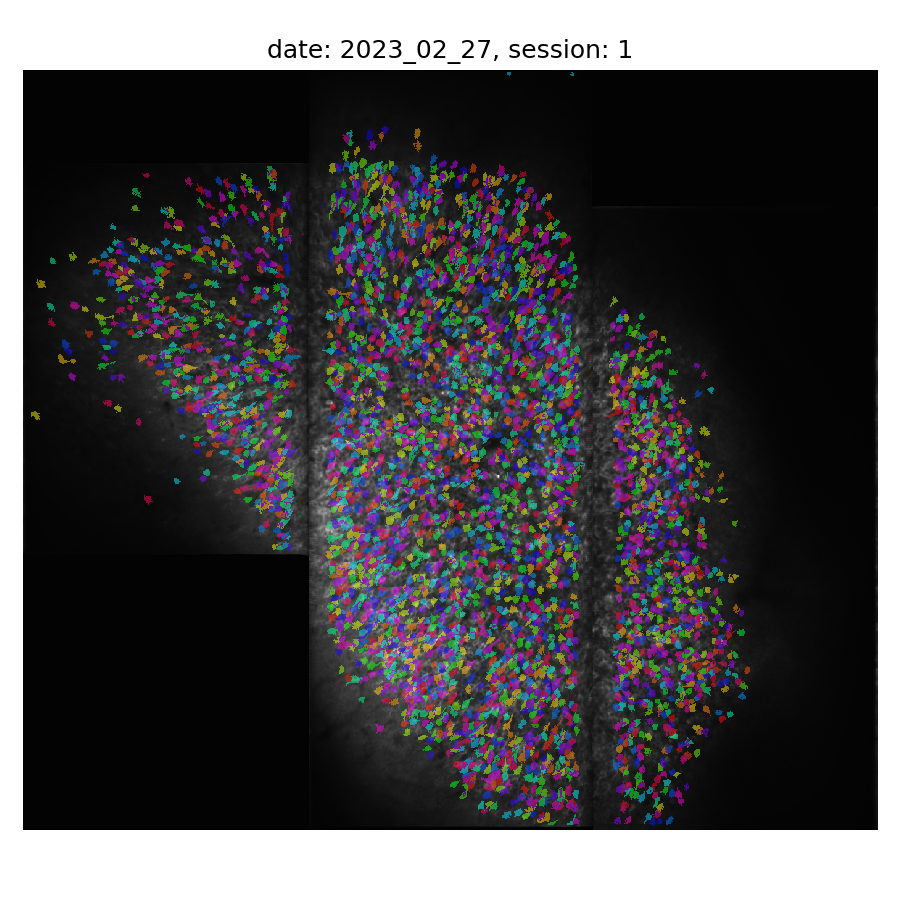

In [17]:
%matplotlib widget
from multiday_suite2p.gui import show_imgs_with_masks

show_imgs_with_masks(sessions,trans_images,{'Registered Cell Masks':trans_label_im})

# Cluster cell masks.

Cell masks across different session are clustered together based on their jaccard distance using complete linkage hierarchical clustering. A template mask is then created for each cluster based on how often a pixel is present in different session for that cluster. Only mask clusters that have been detected in a certian minimum number of sessions are included.

In [ ]:
%%time
from multiday_suite2p.transform import cluster_cell_masks
# cluster and create template masks.
matched_cells, matched_im = cluster_cell_masks(trans_masks, im_size, settings['clustering'])

In [ ]:
from multiday_suite2p.transform import create_template_masks
template_masks, template_im = create_template_masks(matched_cells, im_size, settings['clustering'])

### Save

In [ ]:
with open(registration_data_folder(data_info)/'match.pkl', 'wb') as f:
    pickle.dump([matched_cells, matched_im, template_masks, template_im], f)

### Load

In [ ]:
with open(registration_data_folder(data_info)/'match.pkl','rb') as f:  
    [matched_cells, matched_im, template_masks, template_im] = pickle.load(f)

# View mask clustering results

Use Matplotlib build-in widgets to zoom in/out and pan.

In [ ]:
%matplotlib widget
from multiday_suite2p.gui import show_imgs_with_masks

show_imgs_with_masks(sessions,trans_images,{'Clustered Masks': matched_im,'Individual Masks': trans_label_im,'Template Masks': template_im})

# Backward transform masks
Perform backwards transform of filtered template masks to original sample space of each session.

In [ ]:
from multiday_suite2p.transform import backward_transform_masks
# Backward transform masks.
deform_masks, deform_label_ims, deform_lam_ims = \
    backward_transform_masks(template_masks, deforms)

### Save

In [ ]:
with open(registration_data_folder(data_info)/'filter.pkl', 'wb') as f:
    pickle.dump([deform_masks, deform_label_ims, deform_lam_ims,template_masks], f)

### Load

In [ ]:
with open(registration_data_folder(data_info)/'filter.pkl','rb') as f:  
    [deform_masks, deform_label_ims, deform_lam_ims, template_masks] = pickle.load(f)

# View backward transform result

Use Matplotlib build-in widgets to zoom in/out and pan.

In [ ]:
%matplotlib widget
from multiday_suite2p.gui import show_imgs_with_masks

# add lambda weights image
added_images = images
for i, img_session in enumerate(added_images):
    img_session['lambda_weights'] = deform_lam_ims[i]
show_imgs_with_masks(sessions,added_images,{'Backward Transformed Masks': deform_label_ims})

# Export results
Exports results to 'multi-day' folder.

In [ ]:
from multiday_suite2p.io import export_masks_and_images
export_masks_and_images(deform_masks,template_masks, trans_images, images,sessions, data_info, settings)

# Run trace extraction
Sends Parallel jobs to the cluster to extract traces for each session with new cell masks.
Logs will be saved in "linux root"/logs

<mark>**Note: Run only once untill they are completed ! (see cell below to check progress)**</mark>

Otherwise you risk spamming the cluster and having processes access the same files

## The force_recalc option

<mark>**Be mindfull of the force_recalc option**</mark>

### force_recalc=True

Setting this to True will recalculate the trace extraction even if a result trace file is already present for that session.

Do this in case you changed some settings and want to calculate a new result even if an old result trace file is already present

### force_recalc=False

Setting force_recalc to False will only start jobs for sessions that do not have a result file.

Do this in case a job fails due to a cluster issues and you only want to rerun a few jobs with the same settings.

In [ ]:
from pathlib import Path
from multiday_suite2p.process import extract_local

force_recalc=True # Setting this to true will cause recalculation of sessions that already have a result trace file.

info = np.load(Path(data_info['data']['local_processed_root'])/data_info['data']['output_folder']/'info.npy',allow_pickle=True).item()
jobs = [extract_local(data_info, settings, data_path,force_recalc=force_recalc) for data_path in info['data_paths']]

or

In [ ]:
from pathlib import Path
from multiday_suite2p.cluster.jobs import extract_job

force_recalc=True # Setting this to true will cause recalculation of sessions that already have a result trace file.

info = np.load(Path(data_info['data']['local_processed_root'])/data_info['data']['output_folder']/'info.npy',allow_pickle=True).item()
jobs = [extract_job(data_info, settings, data_path,force_recalc=force_recalc) for data_path in info['data_paths']]

# Monitor Jobs

Here you can monitor the progress of the extraction jobs.
If some jobs are set to 'DONE' but the trace files are still absent you can check the logs ("linux root"/logs) and rerun the jobs (above)

In [ ]:
from multiday_suite2p.cluster.jobs import check_job_status
for job in jobs:
    check_job_status(job, data_info, settings)